In [ ]:
#test

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("/content/drive/MyDrive/ML/CS 4641 ML Project/uber-raw-data-sep14.csv")
data["Date/Time"] = data["Date/Time"].map(pd.to_datetime)
data.head()

FileNotFoundError: ignored

In [ ]:
#Data Cleaning
#Parse through Uber dataset and graph the different metrics. If there is a null or missing data that will be excluded.
#The type of regression needed will be determined after analyzing the plots.
data["Day"] = data["Date/Time"].apply(lambda x: x.day)
data["Weekday"] = data["Date/Time"].apply(lambda x: x.weekday())
data["Hour"] = data["Date/Time"].apply(lambda x: x.hour)
print(data.head())

sns.set(rc={'figure.figsize':(12, 10)})
sns.displot(data["Day"])

sns.displot(data["Hour"])

sns.displot(data["Weekday"])

df = data.groupby(["Weekday", "Hour"]).apply(lambda x: len(x))
df = df.unstack()
sns.heatmap(df, annot=False)

data.plot(kind='scatter', x='Lon', y='Lat', alpha=0.4, s=data['Day'], label='Uber Trips',
figsize=(12, 8), cmap=plt.get_cmap('jet'))
plt.title("Uber Trips Analysis")
plt.legend()
plt.show()

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Feature Seleciton and More Cleaning

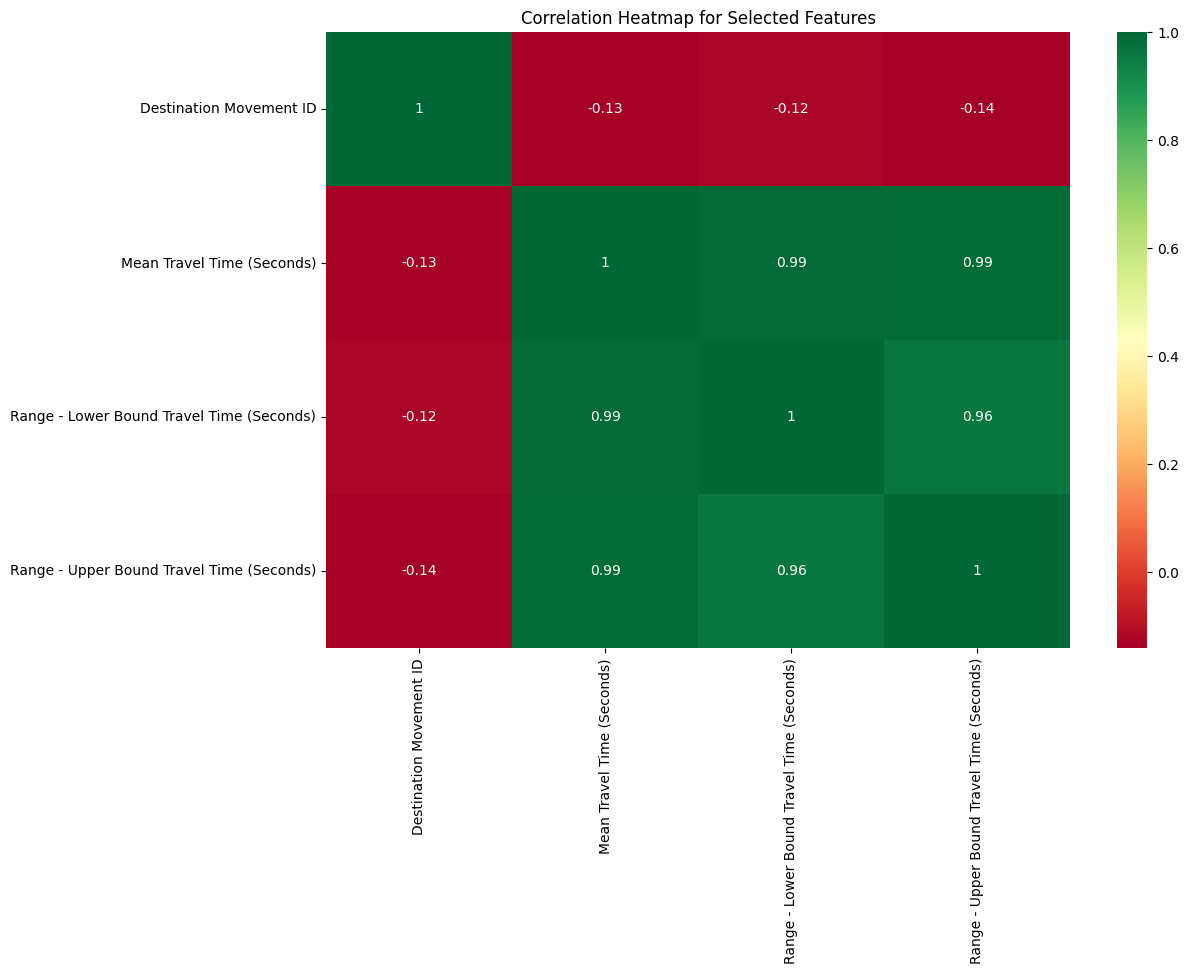

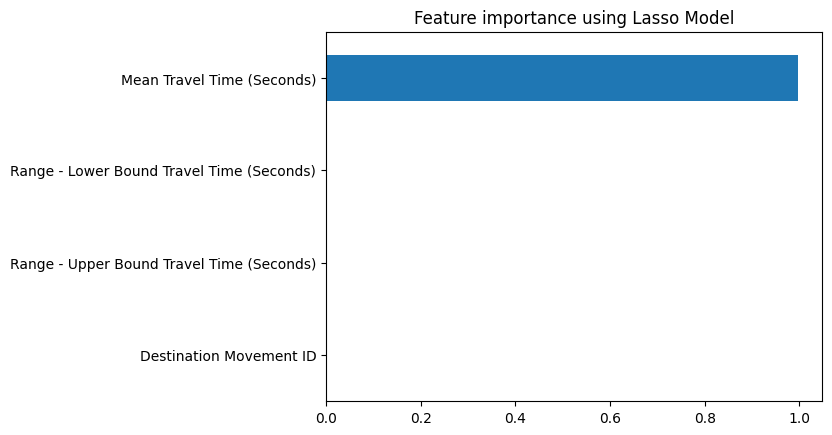

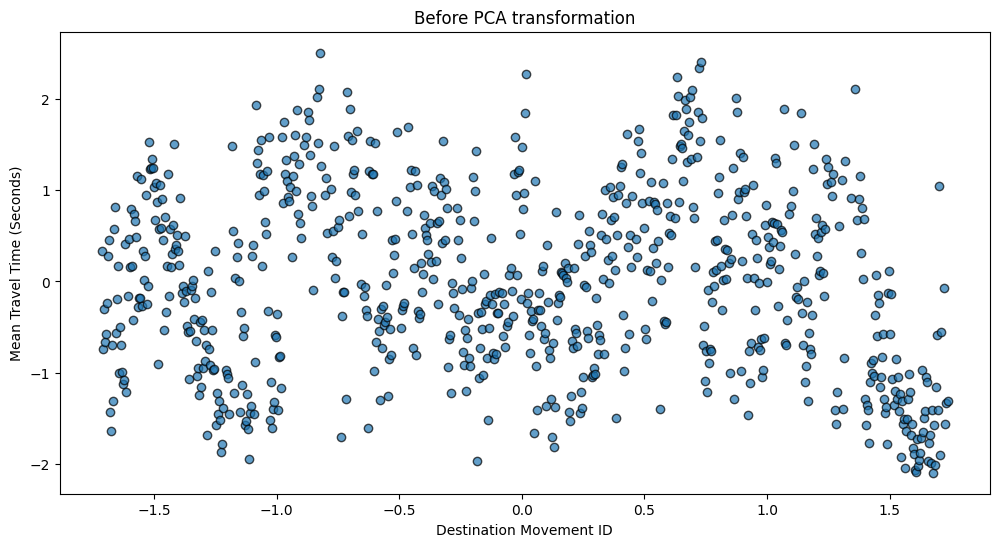

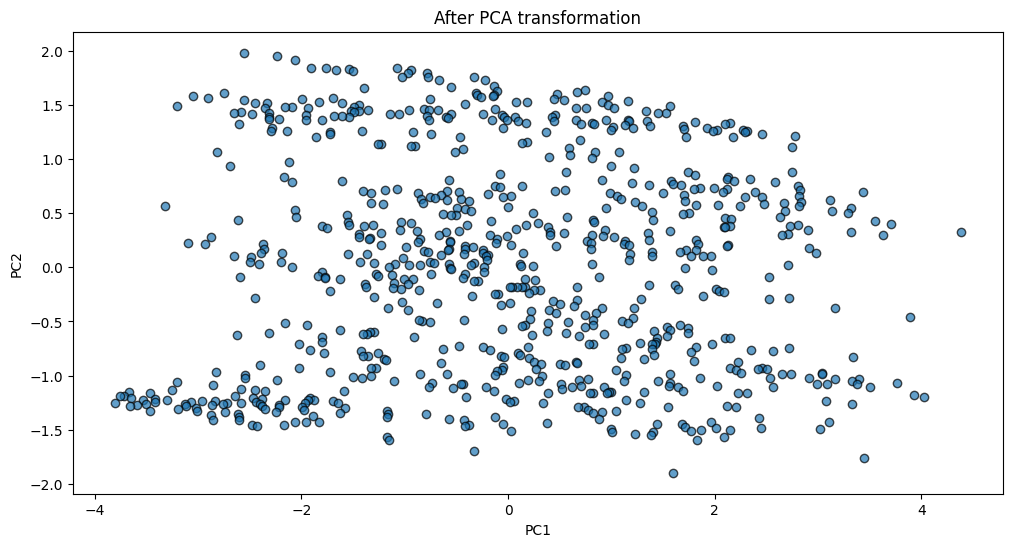

In [4]:
# Load necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns

# Load the original data
df = pd.read_csv('Travel_Times.csv')

# Define categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Handle missing data
for column in categorical_cols:
    df[column].fillna('Unknown', inplace=True)

imputer = SimpleImputer(strategy='median')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])


for column in categorical_cols:
    top10 = df[column].value_counts().index[:10]
    df[column] = np.where(df[column].isin(top10), df[column], 'Other')

df = pd.get_dummies(df, columns=categorical_cols)

# Scale the numerical columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Correlation matrix with Heatmap for selected features
selected_features = ['Destination Movement ID', 'Mean Travel Time (Seconds)', 'Range - Lower Bound Travel Time (Seconds)', 'Range - Upper Bound Travel Time (Seconds)']
corrmat = df[selected_features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corrmat, annot=True, cmap="RdYlGn")
plt.title("Correlation Heatmap for Selected Features")
plt.show()

# Apply LASSO
lasso = LassoCV()
lasso.fit(df[selected_features], df['Mean Travel Time (Seconds)'])
coef = pd.Series(lasso.coef_, index = df[selected_features].columns)
imp_coef = coef.sort_values()
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

# Apply PCA
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df[selected_features]), columns=['PC1', 'PC2'])

# Visualizing before PCA transformation
plt.figure(figsize=(12, 6))
plt.scatter(df[selected_features[0]], df[selected_features[1]], edgecolor='k', alpha=0.7)
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title(f'Before PCA transformation')
plt.show()

# Visualizing the PCA transformation
plt.figure(figsize=(12, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], edgecolor='k', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'After PCA transformation')
plt.show()

Code for XGBoost and LightGBM Model (test data, not actual data)

100%|██████████| 7/7 [01:46<00:00, 15.19s/it]


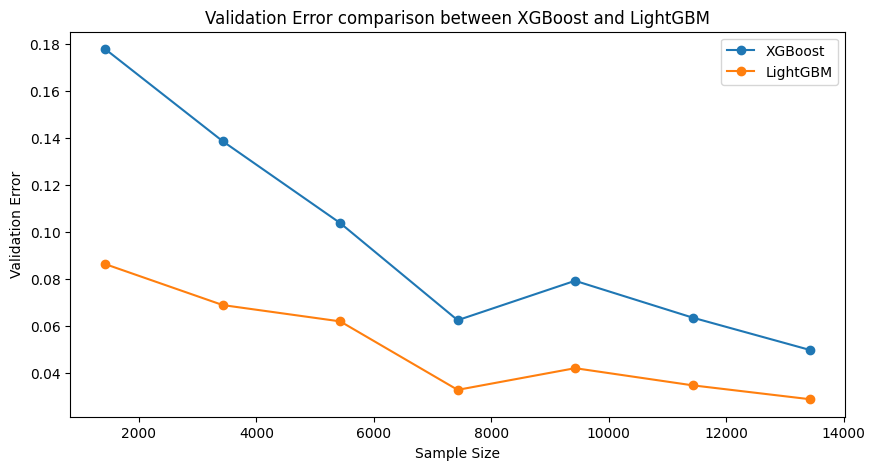

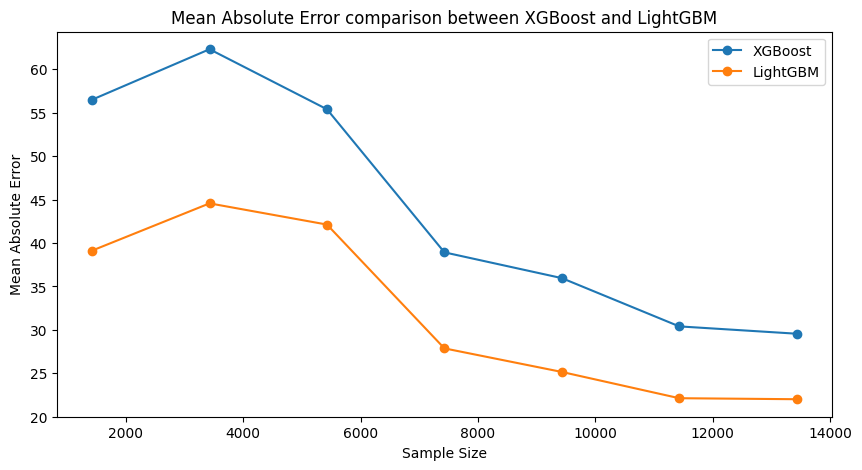

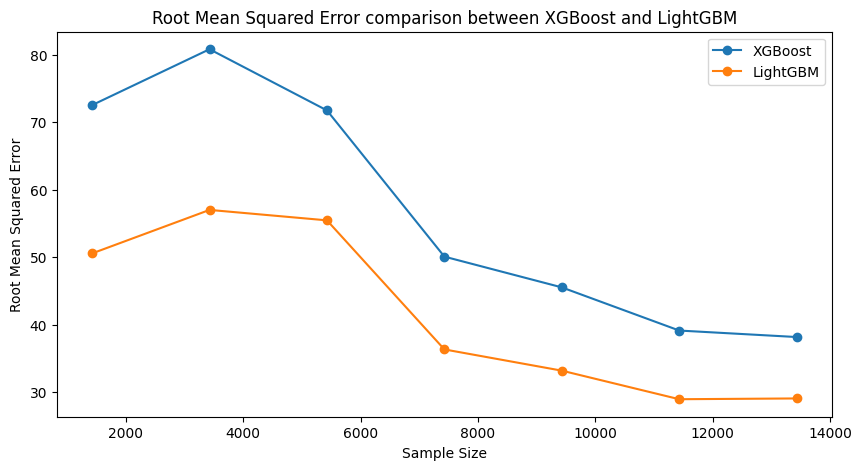

In [ ]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import make_regression
from math import sqrt

import time
from tqdm import tqdm

# configuration
min_samples = 1000
max_samples = 10000
step = 2000

# Dictionaries to store metrics
xgb_metrics = {"sample_size": [], "runtime": [], "mae": [], "rmse": [], "val_error": []}
lgbm_metrics = {"sample_size": [], "runtime": [], "mae": [], "rmse": [], "val_error": []}

for sample_size in tqdm(range(int(min_samples/0.7), int(max_samples/0.7), step)):
  xgb_dummy = XGBRegressor(random_state=42, max_depth=6, n_jobs=-1) #default max depth determined from https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/max_depth.html#:~:text=The%20max_depth%20default%20value%20varies,XGBoost%3A%20default%20is%206.
  lgbm_dummy = LGBMRegressor(random_state=42, max_depth=5, n_jobs=-1) #default max depth determined from https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/max_depth.html#:~:text=The%20max_depth%20default%20value%20varies,XGBoost%3A%20default%20is%206.

  # generating the dataset of custom sample size
  dummy = make_regression(n_samples=sample_size)

  # splitting the data into train/validation/test sets
  X_temp, X_test, y_temp, y_test = train_test_split(dummy[0], dummy[1], test_size=0.15, random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

  # XGBoost
  start = time.time()
  xgb_dummy.fit(X_train, y_train)
  end = time.time()
  # storing metrics
  xgb_metrics["runtime"].append(end-start)
  xgb_metrics["sample_size"].append(sample_size)
  predictions = xgb_dummy.predict(X_val)
  xgb_metrics["mae"].append(mean_absolute_error(y_val, predictions))
  xgb_metrics["rmse"].append(sqrt(mean_squared_error(y_val, predictions)))
  xgb_metrics["val_error"].append(1 - xgb_dummy.score(X_val, y_val))  # error is 1 - score

  # LightGBM
  start = time.time()
  lgbm_dummy.fit(X_train, y_train)
  end = time.time()
  # storing metrics
  lgbm_metrics["runtime"].append(end-start)
  lgbm_metrics["sample_size"].append(sample_size)
  predictions = lgbm_dummy.predict(X_val)
  lgbm_metrics["mae"].append(mean_absolute_error(y_val, predictions))
  lgbm_metrics["rmse"].append(sqrt(mean_squared_error(y_val, predictions)))
  lgbm_metrics["val_error"].append(1 - lgbm_dummy.score(X_val, y_val))  # error is 1 - score

# plot validation error comparison
plt.figure(figsize=(10, 5))
plt.plot(xgb_metrics["sample_size"], xgb_metrics["val_error"], marker='o', label='XGBoost')
plt.plot(lgbm_metrics["sample_size"], lgbm_metrics["val_error"], marker='o', label='LightGBM')
plt.xlabel('Sample Size')
plt.ylabel('Validation Error')
plt.title('Validation Error comparison between XGBoost and LightGBM')
plt.legend()
plt.show()

# plot MAE comparison
plt.figure(figsize=(10, 5))
plt.plot(xgb_metrics["sample_size"], xgb_metrics["mae"], marker='o', label='XGBoost')
plt.plot(lgbm_metrics["sample_size"], lgbm_metrics["mae"], marker='o', label='LightGBM')
plt.xlabel('Sample Size')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error comparison between XGBoost and LightGBM')
plt.legend()
plt.show()

# plot RMSE comparison
plt.figure(figsize=(10, 5))
plt.plot(xgb_metrics["sample_size"], xgb_metrics["rmse"], marker='o', label='XGBoost')
plt.plot(lgbm_metrics["sample_size"], lgbm_metrics["rmse"], marker='o', label='LightGBM')
plt.xlabel('Sample Size')
plt.ylabel('Root Mean Squared Error')
plt.title('Root Mean Squared Error comparison between XGBoost and LightGBM')
plt.legend()
plt.show()
